In [1]:
import numpy as np
import xarray as xr
import rioxarray as rio
import geopandas as gpd
import pandas as pd
from geocube.api.core import make_geocube
from typing import Union
from types import NoneType
from sklearn.linear_model import LinearRegression
from rasterio.enums import Resampling
from glob import glob

import os
import sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent) + "/code/")
from utils import *

# Testing notebook `01_split_forest_nonforest`

We perform two tests for the analysis:

1. We test the performance against synthetic data

2. We make sure that the sum of the landcover types is close to the original sum of the data

## 1. Testing against synthetic data

We have three steps for creating the sytnthetic data:
1. Create a map of land cover for each region using a random sample of coverage - we use a dirichlet distribution to ensure that the sum of the land cover types is 1

2. Create a map of biomass densities that are a linear function of forest and nonforest for each pixel using random parameters for each region

3. Create a map of biomass for each pixel using the land cover map and the biomass densities map

After creating the biomass map for each landcover type, we run the analysis on the sum of both landcover types, and see if we can recover the parameters and the split between forest and nonforest


## 1.1. Load data

In [2]:
# load the Liu et al. data
liu_data = rio.open_rasterio('../data/biomass/liu_et_al_2015/Global_annual_mean_ABC_lc2001_1993_2012_20150331.nc',masked=True)['Aboveground Biomass Carbon']

# set the coordinates to the same as the other datasets
liu_data = xr.DataArray(data=liu_data.values.swapaxes(2,1)[:,:,::-1],
                    coords=[liu_data['time'].values,np.linspace(89.875,-89.875,720),np.linspace(-179.875,179.875,1440)],
                    dims=['time','y','x'])
liu_data = liu_data.rio.write_crs(4326)
liu_data['time'] = liu_data['time'].astype(int)

# load wwf ecoregions
wwf_ecoregions = gpd.read_file('../results/00_preprocessing/agg_wwf_ecoregions.shp')

## 1.2. Use the functions that are defined in the notebook

Note that we changed the threshold for the linear regression to 1 because here there is no issue of noise

In [163]:
def regress_density_region(ds:xr.DataArray) -> xr.DataArray:
    '''
    This function calculates the coefficients of Linear Regression for Land Cover Biomass against Land Cover categories.

    Parameters:
    ds: xarray.DataArray
        The DataArray containing the landcover and biomass data.

    Returns:
    xarray.DataArray
        The coefficients of Linear Regression for Land Cover Biomass against Land Cover categories.
    '''

    # reshape the input data into a 2D array where rows represent each sample and columns represent individual features.
    X = ds.values.reshape((ds.shape[0],-1))

    # extract and flatten the 'biomass' column from the input data, and remove NaN values.
    y = ds['biomass'].values.flatten()
    mask = (~np.isnan(X.sum(axis=0))) & ~np.isnan(y).squeeze() # Squeeze the boolean value into a scalar.
    
    # mask out columns from X that have one or more NaN values, update output variables.
    X = X[:,mask]
    y = y[mask]

    # if the filtered inputs have an N of more than 500 valid features, run Linear Regression to estimate coefficients, else return an empty data array.
    if X.shape[1]>=1:
        # implement Linear Regression with positive constraint on regression weights using the filtered inputs.
        reg = LinearRegression(positive=True,fit_intercept=False).fit(X.T, y)
    
        # return a DataArray containing the learned coefficients with dimensions 'landcover'.
        return xr.DataArray(reg.coef_,dims=['landcover'])
    else:
        # create and return a DataArray with shape 'ds.shape[0]' and all elements initialized with NaN values.
        return xr.DataArray(np.full(ds.shape[0],np.nan),dims=['landcover'])


def regress_density(biomass:xr.DataArray, area_map:xr.DataArray,regions:xr.DataArray) -> np.ndarray:
    '''
    This function calculates the biomass densities for each region based on the regression method.

    Parameters:
    biomass: xarray.DataArray
        The biomass data to be split.
    area_map: xarray.DataArray
        The area map used to define the landcover types.
    regions: xarray.DataArray
        The regions used to define different biomass densities for each landcover.
    
    Returns:
    numpy.ndarray
        The biomass densities for each region for the different landcovers.
    '''

    # create a merged DataArray with the landcover map, the biomass map and the region map
    merged_ds = area_map
    merged_ds['biomass'] = biomass
    merged_ds['area_id'] = regions

    # group the DataArray by region and apply the regression function
    density = merged_ds.groupby('area_id').apply(regress_density_region)

    # convert the result into an ndarray
    density = density.to_dataframe(name='').unstack().T.droplevel(0).reindex(list(range(0,int(merged_ds['area_id'].max().values)+1)),fill_value=np.nan)
    
    return density.values

def get_biomass_density(biomass:Union[xr.DataArray,NoneType],density_args:Union[xr.DataArray,NoneType],regions:xr.DataArray,method:str) -> np.ndarray:
    '''
    This function calculates the biomass densities for each region based on the method used.

    Parameters:
    biomass: Union[xr.DataArray,NoneType]
        The biomass data to be split. If using Xu method, this parameter is not used.
    density_args: Union[xarray.DataArray,NoneType]
        Arguments for calculating the density (area_map for the regression method).
    regions: xarray.DataArray
        The regions used to define different forest/nonforest biomass densities.
    method: str
        The method to use for biomass density calculation. Options are 'xu' and 'song' or 'CCI'.

    Returns:
    numpy.ndarray
        The biomass densities for each region.

    '''
    
    assert method in ['xu','song','CCI'], 'Invalid method. Options are "xu", "song" or "CCI".'
    
    if method == 'xu':
        # load Table 1 from Xu et al.
        xu_biomass_density_df = pd.read_excel('../data/regions_data/xu_et_al_2021/biomass_densities_table1.xlsx')

        # take the columns that report biomass densities
        densities = xu_biomass_density_df.filter(regex='Mg/ha')

        # calculate the average biomass density for 2000 and 2019
        densities = (densities.filter(regex='2000').values + densities.filter(regex='2019').values) / 2
        
        # change the column names to forest and shrub
        xu_biomass_density_df[['forest','shrubland']] = densities

        # set the biomass density to 0 for cropland
        xu_biomass_density_df['cropland'] = 0

        # get the biomass densities and the code for the regions
        densities_per_area = xu_biomass_density_df[['code','forest','shrubland','cropland']].set_index('code').sort_index().values

    if method == 'song':
        # for song et al., calculate density based on average biomass density and average landcover for 
        # the entire period due to non-smooth behavior of the landcover map in time
        densities_per_area = regress_density(biomass.mean(dim='time'),density_args.mean(dim='time'),regions)
    
    if method == 'CCI':
        # regress the biomass densities for each region for each year in biomass
        densities_per_area = np.stack([regress_density(biomass.sel(time=year),density_args.sel(time=year),regions) for year in biomass['time']])

    return densities_per_area
    

def split_biomass(biomass:xr.DataArray,area_frac:xr.DataArray,density_args:Union[xr.DataArray,NoneType], regions:Union[gpd.GeoDataFrame,xr.DataArray], method:str) -> xr.DataArray:
    '''
    This function splits the biomass data into forest and non-forest biomass based on the landcover map and the area fraction of each landcover type.

    The stages of the analysis are:
    - Resample the area fraction data to match the biomass data resolution.
    - Calculate the biomass densities based on the method used.
    - Split the biomass data into forest and non-forest biomass based on the landcover map and the area fraction of each landcover type.

    Parameters:
    biomass: xarray.DataArray
        The biomass data to be split.
    area_frac: xarray.DataArray
        The area fraction of each landcover type.
    density_args: Union[xarray.DataArray,NoneType]
        Arguments for calculating the density (area_map for the regression method).
    regions: xarray.DataArray or geopandas.GeoDataFrame
        The regions used to define different forest/nonforest biomass densities.
    method: str
        The method to use for biomass density calculation. Options are 'xu' and 'song' or 'CCI'.
    
    Returns:
    xarray.DataArray
        The split biomass data.
    '''
    
    assert method in ['xu','song','CCI'], 'Invalid method. Options are "xu", "song" or "CCI".'

    ## 1. Resampling of input data ##

    
    # select the time period of the area fraction data that matches the biomass data
    area_frac = area_frac.sel(time = biomass.time)
    
    # resample the area fraction data to match the biomass data resolution
    area_frac = xr.concat([resample_match(area_frac.sel(landcover=i),biomass) for i in area_frac['landcover']],dim='landcover')

    # remove artifacts from the resampling
    area_frac = area_frac.where(area_frac<1e30)

    if method != 'xu':
        # for both regression based approaches ('song' or 'CCI'), the regions are the wwf ecoregions. We convert the GeoDataFrame to a xr.DataArray
        regions = make_geocube(vector_data=regions,measurements=['id'],like= biomass)['id']

        # for the regression based approaches, we need a forest area map ('song' or 'CCI'), so we need to resample the area map to match the biomass data resolution
        if method == 'CCI':
            # avoid resampling twice if CCI is used both for the area and also for the regression
            density_args = area_frac
        else:
            density_args = xr.concat([resample_match(density_args.sel(landcover=i),biomass) for i in density_args['landcover']],dim='landcover')
    
    # resample regions to match the biomass data resolution
    regions = regions.rio.reproject_match(biomass[0,:,:],nodata=np.nan, resampling=Resampling.nearest)

    ## 2. Calculate biomass densities ##
    # calculate the biomass densities per region
    densities_per_area = get_biomass_density(biomass,density_args,regions,method=method)
    
    # create a mask for NaN values for the regions
    nan_mask = np.isnan(regions.values)

    if len(densities_per_area.shape) == 2:
        # if densities do not have a time dimension (xu or song method) add the time dimension
        densities_per_area = densities_per_area[np.newaxis,:,:]

    # fill in NaN values in the biomass density by using the weighted mean of regions with valid values based on their dominance terms of area
    # count the occurance of each region in the biomass data
    region_counts = regions.where(biomass.mean(dim='time')>0).to_dataframe('id')['id'].value_counts()

    # calculate the weighted average biomass density based on the occurances of each region and their biomass densities
    average_densities = np.nansum(densities_per_area[:,region_counts.index.astype(int),:].transpose(0,2,1) * (region_counts/region_counts.sum()).values,axis=2)

    # fill in NaN values in the biomass density using the time average on the average_densities
    densities_per_area[np.isnan(densities_per_area.sum(axis=2))] = average_densities.mean(axis=0)

    #convert the biomass densities per area into maps of biomass density using the region map
    density = densities_per_area[:,regions.fillna(0).values.astype(int)]
    
    # reapply the NaN mask
    density[:,nan_mask,:] = np.nan    

    # transpose the density data to match the dimensions of the biomass data
    density = density.transpose(3,1,2,0)

    ## 3. Split biomass data ##

    # calculate the fraction of biomass for each landcover type
    fraction = density*area_frac.transpose('landcover','y','x','time')
    fraction = (fraction/fraction.sum(dim='landcover')).transpose('landcover','time','y','x')

    # multiply by the total biomass to get the final answer 
    result = fraction * biomass

    # if landcover has three values, we need to sum cropland and shrubland into nonforest
    if 'cropland' in result['landcover']:
        nonforest = result.sel(landcover=['cropland','shrubland']).sum(dim='landcover').expand_dims('landcover')
        nonforest['landcover'] = ['nonforest']
        result = xr.concat([result.sel(landcover=['forest']),nonforest],dim='landcover')

    return result

## 1.3. Run the analysis

### 1.3.1 Create synthetic data

In [132]:
np.random.seed(0)
# initialize variables

# create a landcover map
landcover = xr.concat([xr.zeros_like(liu_data[0,:,:]) for i in range(3)],dim='landcover')
landcover['landcover'] = ['forest','nonforest','barren']

# create random land cover map. Use Dirichlet random variables to ensure that the sum of the land cover types is 1
np.random.seed(0)
landcover = (landcover + np.random.dirichlet(np.ones(3),size=landcover.shape[1:]).transpose(2,0,1)).where(liu_data[0,:,:].notnull())

# create random biomass densities for the different ecoregions
np.random.seed(1000)
biomass_densities = np.random.uniform(0,200,[wwf_ecoregions.shape[0],2])

# set the ecoregions id to be the order of the ecoregions to be consistent with the random biomass density data
wwf_ecoregions['id']=np.arange(wwf_ecoregions.shape[0])

# convert the vector ecoregion data to a raster to create the map based on which the biomass densities will be determined
ecoregion_raster = make_geocube(vector_data=wwf_ecoregions,measurements=['id'],like= landcover)['id'].fillna(-1)

# create biomass density map 
biomass_density_map = biomass_densities[ecoregion_raster.values.astype(int)].transpose(2,0,1)
# biomass_density_map = biomass_density_map + np.random.normal(0,1,biomass_density_map.shape)

# create the biomass map by multiplying the biomass densities with the landcover map
biomass_map = biomass_density_map * landcover[:2,:,:] 

# expand the dimensions of the biomass map and the landcover map to have a time dimension
biomass_map = biomass_map.expand_dims('time')

# for the landcover map, take only the forest and nonforest landcover types
landcover = landcover.expand_dims('time')[:,:2,:,:]

### 1.3.2. Run the analysis

In [164]:
r = split_biomass(biomass     = biomass_map.sum(dim='landcover'),
                       area_frac   = landcover,
                       density_args   = landcover,
                       regions       = wwf_ecoregions,
                       method         = 'song'
                       
                       )

### 1.3.3. Compare the results against the simulation

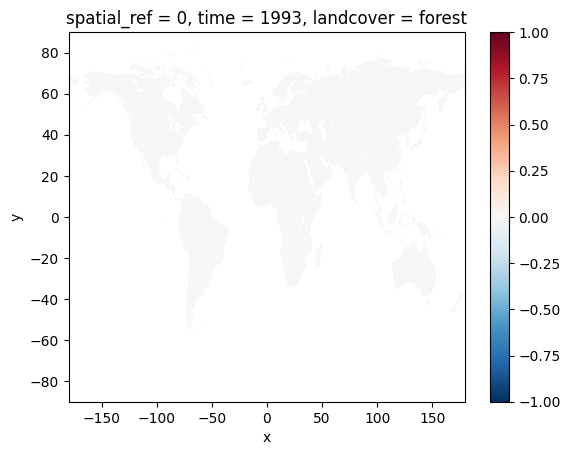

In [165]:
(biomass_map[0,0,:,:]-r[0,0,:,:]).plot(vmin=-1,vmax=1,cmap='RdBu_r')

## 2. Testing the sum of the landcover types

## 2.1. Load the data

### [Liu et al. (2015)](https://www.nature.com/articles/nclimate2581)

In [2]:
liu_data = rio.open_rasterio('../data/biomass/liu_et_al_2015/Global_annual_mean_ABC_lc2001_1993_2012_20150331.nc',masked=True)['Aboveground Biomass Carbon']

# set the coordinatess to the same as the other datasets
liu_data = xr.DataArray(data=liu_data.values.swapaxes(2,1)[:,:,::-1],
                    coords=[liu_data['time'].values,np.linspace(89.875,-89.875,720),np.linspace(-179.875,179.875,1440)],
                    dims=['time','y','x'])
liu_data = liu_data.rio.write_crs(4326)
liu_data['time'] = liu_data['time'].astype(int)

### [Xu et al. (2021)](https://www.science.org/doi/10.1126/sciadv.abe9829)

In [3]:
# Load data
xu_data = rio.open_rasterio('../data/biomass/xu_et_al_2021/test10a_cd_ab_pred_corr_2000_2019_v2.tif',masked=True,chunks='auto')

# set the year dimension to by integer years
xu_data['time'] = xu_data['time'].dt.year

### [Chen et al. (2023)](https://essd.copernicus.org/articles/15/897/2023/)

In [4]:
# Load data
files = [sorted(glob(f'../data/biomass/chen_et_al_2023/DATA/{i}/*.tif')) for i in ['AGBC','BGBC']]
chen_agb = xr.open_mfdataset(files[0],concat_dim='time',combine='nested').squeeze()['band_data']
chen_bgb = xr.open_mfdataset(files[1],concat_dim='time',combine='nested').squeeze()['band_data']

# combine above and below ground biomass
chen_data = chen_agb.copy()
chen_data[:] = chen_agb.values + chen_bgb.values

# set the time dimension to integer years
chen_data['time'] = [int(i.split('.')[2][-4:]) for i in files[0]]

# set the nodata variable
chen_data.rio.set_nodata(np.nan,inplace=True)

# down sample to 0.1 degree resolution
chen_data = down_sample(chen_data,x_factor=12,y_factor=12,stat='mean')
chen_data = chen_data.where(chen_data>0)

# drop year 2021
chen_data = chen_data.sel(time=chen_data['time']!=2021)

### L-VOD data

In [5]:
LVOD_data = xr.open_dataset('../data/biomass/LVOD/AGC_vod_annual_NOAA_Trend_corrected_lat_lon_merged.nc')['AGC_ASC_DESC']
LVOD_data.rio.write_crs(4326,inplace=True);

LVOD_data_ASC_DESC = LVOD_data[0,:,:,:]
LVOD_data_ASC_DESC_max = LVOD_data[1,:,:,:]
LVOD_data_ASC_DESC_min = LVOD_data[2,:,:,:]

## 2.2. Run the analysis

In [7]:
# find all results of the analysis
files = glob('../results/01_split_forest_nonforest/*.nc')

# extract the source dataset for each file
file_source = pd.Series(files).str.split('/').str[-1].str.split('_').str[0].values

# define a dictionary which maps the name of the source dataset to the respective variable
reference_dict = {'xu':xu_data,'liu':liu_data,'chen':chen_data,'LVOD':LVOD_data_ASC_DESC,'LVODmax':LVOD_data_ASC_DESC_max,'LVODmin':LVOD_data_ASC_DESC_min}

# run over each file
for i in range(len(files)):

    # load the result file
    ds = xr.open_dataarray(files[i])

    # calculate the total biomass for each time summing over landcovers
    ds_sum = (100*ds.sum(dim='landcover')*calc_area(ds)).sum(dim=['x','y'])

    # calculate the total biomass for each time for the original data
    ref_sun = (100*reference_dict[file_source[i]]*calc_area(reference_dict[file_source[i]])).sum(dim=['x','y'])

    # calculate the relative difference between the results
    diff = (1-ds_sum/ref_sun)

    # print the maximal difference across years
    print(f'{files[i]}: {diff.max().values:.3f}')

    # assert that the maximal difference is less than 5%
    assert any((1-ds_sum/ref_sun) < 0.05), "FAIL"

../results/01_split_forest_nonforest/liu_biomass_xu.nc: 0.008
../results/01_split_forest_nonforest/liu_biomass_song.nc: 0.009


In [12]:
# find all results of the analysis
files = glob('../results/01_split_forest_nonforest/*.nc')

# extract the source dataset for each file
file_source = pd.Series(files).str.split('/').str[-1].str.split('_').str[0].values

# define a dictionary which maps the name of the source dataset to the respective variable
reference_dict = {'xu':xu_data,'liu':liu_data,'chen':chen_data,'LVOD':LVOD_data_ASC_DESC,'LVODmax':LVOD_data_ASC_DESC_max,'LVODmin':LVOD_data_ASC_DESC_min}

# run over each file
for i in range(len(files)):

    # load the result file
    ds = xr.open_dataarray(files[i])

    # calculate the total biomass for each time summing over landcovers
    ds_sum = (100*ds.sum(dim='landcover')*calc_area(ds)).sum(dim=['x','y']).diff(dim='time').mean(dim='time').sum()

    # calculate the total biomass for each time for the original data
    ref_sun = (100*reference_dict[file_source[i]]*calc_area(reference_dict[file_source[i]])).sum(dim=['x','y']).diff(dim='time').mean(dim='time')

    # calculate the relative difference between the results
    diff = np.abs(1-ds_sum/ref_sun)

    # print the maximal difference across years
    print(f'{files[i]}: analyzed:{ds_sum.values/1e15:.2f}, original:{ref_sun.values/1e15:.2f} {diff.max().values:.3f}')

    # assert that the maximal difference is less than 15%
    # assert np.abs(1-ds_sum/ref_sun) < 0.15, "FAIL"

../results/01_split_forest_nonforest/liu_biomass_xu.nc: analyzed:-0.11, original:-0.11 0.012
../results/01_split_forest_nonforest/liu_biomass_song.nc: analyzed:-0.11, original:-0.11 0.031
../results/01_split_forest_nonforest/liu_biomass_CCI.nc: analyzed:-0.11, original:-0.11 0.013
../results/01_split_forest_nonforest/xu_biomass_xu.nc: analyzed:0.24, original:0.24 0.000
../results/01_split_forest_nonforest/xu_biomass_song.nc: analyzed:0.23, original:0.24 0.010
../results/01_split_forest_nonforest/xu_biomass_CCI.nc: analyzed:0.26, original:0.24 0.108
../results/01_split_forest_nonforest/chen_biomass_xu.nc: analyzed:0.12, original:0.12 0.000
../results/01_split_forest_nonforest/chen_biomass_song.nc: analyzed:0.11, original:0.12 0.008
../results/01_split_forest_nonforest/chen_biomass_CCI.nc: analyzed:0.12, original:0.12 0.000
../results/01_split_forest_nonforest/LVOD_xu.nc: analyzed:3.02, original:3.18 0.050
../results/01_split_forest_nonforest/LVOD_song.nc: analyzed:3.02, original:3.18 0.